# Setup

In [ ]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=5e7ef4741c965d1d82dae133272e6020dbd7a99e47190df468a5dabe03a1f9dc
  Stored in directory: /root/.cache/pip/wheels/07/93/05/72c05349177dca2e0ba31a33ba4f7907606f7ddef303517c6a
Successfully built wikipedia


In [ ]:
import logging
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set()

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

# Criação do Grafo

In [ ]:

def create_graph(args: dict) -> nx.DiGraph:
  logger.info("[INFO] Creating graph")

  # organizating the search
  todo_lst = [(0, args['SEED'])] # The SEED is in the layer 0
  todo_set = set(args['SEED']) # The SEED itself
  done_set = set() # Nothing is done yet

  # creating the initial graph
  g = nx.DiGraph()
  layer, page = todo_lst[0]

  if os.path.isfile('extract.txt'):
    file = open('extract.txt', 'w')
  else:
    file = open('extract.txt', 'x')
    
  while layer < 2:
    # Remove the name page of the current page from the todo_lst, 
    # and add it to the set of processed pages. 
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)
    
    # Show progress
    # print(layer, page)
    file.write(f"{layer} {page}\n")
    
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      # print("Could not load", page)
      file.write("Could not load\n")
      layer, page = todo_lst[0]
      continue
    
    for link in wiki.links:
      link = link.title()
      if link not in args['STOPS'] and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  # close the file
  file.close()
  
  return g

# Processamento dos nós da rede

In [ ]:
def preprocessing(g: nx.DiGraph) -> nx.DiGraph:
  logger.info("[INFO] Starting preprocessing")

  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  if os.path.isfile('preprocessing.txt'):
    file2 = open('preprocessing.txt', 'w')
  else:
    file2 = open('preprocessing.txt', 'x')

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")
  file2.close()

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  file2.close()
  return g

In [ ]:
def plot_histogram(g: nx.DiGraph):
  plt.style.use("default")
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,1,figsize=(8,4))

  ax.hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax.set_title("Degree Histogram")
  ax.set_ylabel("Count")
  ax.set_xlabel("Degree")
  ax.set_xlim(0,10)
  ax.set_ylim(0,15000)

  plt.tight_layout()
  plt.savefig('degree_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [ ]:
def truncate(g: nx.DiGraph):
  logger.info("[INFO] Starting to truncate the network")

  # checking the degree for each node
  plot_histogram(g)

  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  logger.info("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  # reporting the final graph
  nx.write_graphml(gsub, "cna.graphml")

  logger.info("Nodes removed: {:.2f}%".format(100*(1 - len(gsub)/len(g))))
  logger.info("Edges removed: {:.2f}%".format(100*(1 - nx.number_of_edges(gsub)/nx.number_of_edges(g))))
  logger.info("Edges per nodes: {:.2f}".format(nx.number_of_edges(gsub)/len(gsub)))

# Análise da rede

## Nós mais citados

In [ ]:
def most_significant_nodes(g: nx.DiGraph):
  logger.info("[INFO] Getting the most significant nodes")
  # getting the most significant nodes with their respective number of connections
  top_indegree = sorted(dict(g.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]

  # writing in a file
  if os.path.isfile('most_sig_nodes.txt'):
    file3 = open('most_sig_nodes.txt', 'w')
  else:
    file3 = open('most_sig_nodes.txt', 'x')

  file3.write("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))
  file3.close()

## Composição do Núcleo (Core e Shell)

In [ ]:
def core_composition(g: nx.DiGraph):
  logger.info("[INFO] Exploring core composition")
  # how many k-cores does this network have
  k_cores = set([v for k,v in nx.core_number(g).items()])

  logger.info(f"[INFO] K-cores: {k_cores}")
  logger.info(f"[INFO] K-cores length: {len(k_cores)}")

  # who are in the innermost k-core
  k_shell = list(nx.k_shell(g, 101))

  logger.info(f"[INFO] K-shell: {k_shell}")
  logger.info(f"[INFO] K-shell length: {len(k_shell)}")

  if os.path.isfile('k_shell.txt'):
    file4 = open('k_shell.txt', 'w')
  else:
    file4 = open('k_shell.txt', 'x')

  for shell in k_shell:
    file4.write(f"{shell}\n")

  file4.close()

In [ ]:
def explore_network(g: nx.DiGraph):
  g = nx.read_graphml('cna.graphml')
  most_significant_nodes(g)
  core_composition(g)
     

def compose (*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    return inner
     

# Resultados

11-12-2022 19:23:42 [INFO] Creating graph
/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
11-12-2022 19:24:55 [INFO] Starting preprocessing
11-12-2022 19:25:47 [INFO] Starting to truncate the network


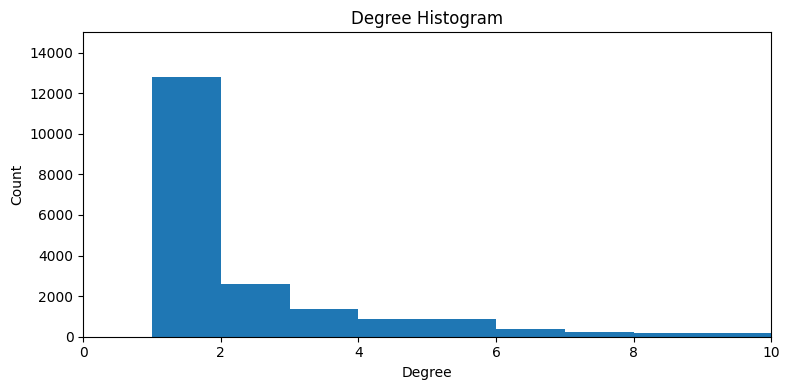

11-12-2022 19:25:49 7427 nodes, 44759 edges
11-12-2022 19:25:51 Nodes removed: 63.30%
11-12-2022 19:25:51 Edges removed: 22.25%
11-12-2022 19:25:51 Edges per nodes: 6.03
11-12-2022 19:25:53 [INFO] Getting the most significant nodes
11-12-2022 19:25:53 [INFO] Exploring core composition
11-12-2022 19:25:53 [INFO] K-cores: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 66, 69, 70, 83, 85, 86, 94, 97, 101}
11-12-2022 19:25:53 [INFO] K-cores length: 66
11-12-2022 19:25:53 [INFO] K-shell: ['Birmingham School (Economics)', 'Feminist Economics', 'Thermoeconomics', 'New Neoclassical Synthesis', 'Social Credit', 'Marxism And Keynesianism', 'Rational Expectations', 'Evolutionary Economics', 'Monetarism', 'Structuralist Economics', 'School Of Salamanca', 'Socialist Economics', 'New Institutional Economics', 'Real Business-Cycl

In [ ]:
# setup seed and stops
SEED = "Thermoeconomics".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Issn (Identifier)", 
         "Pubmed Central",
         "Digital Object Identifier", 
         "Arxiv",
         "Proc Natl Acad Sci Usa", 
         "Bibcode",
         "Library Of Congress Control Number", 
         "Jstor",
         "Doi (Identifier)",
         "S2Cid (Identifier)",
         "Jstor (Identifier)",
         "Oclc (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")

args = {
    'SEED': SEED,
    'STOPS': STOPS
}
     

composed = compose(create_graph, preprocessing, truncate, explore_network)
composed(args)